# Прогноз количества заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Подготовка данных

Импортируем необходимые библиотеки.

In [3]:
import pandas as pd
import numpy as np
import time
import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, KFold
import lightgbm as lgb
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import RFE
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

Сохраним данные в датафрейм.

In [4]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

### Изучение данных

#### Общее изучение данных

Выведем общую информацию о датафрейме, а также первые и последние 5 строк.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Построим график временного ряда.

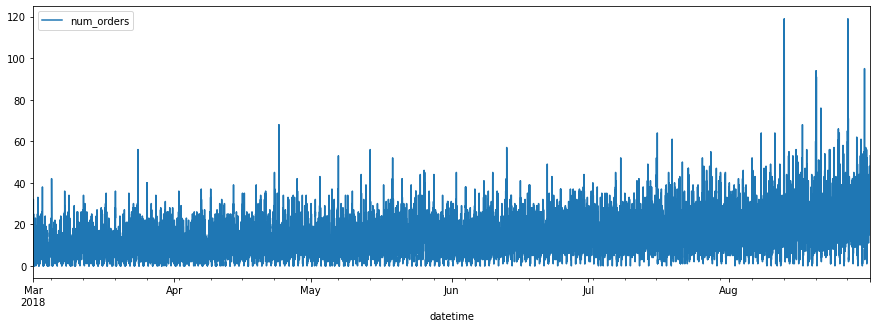

In [7]:
data.plot(figsize=(15,5));

#### Ресамплинг

Сделаем передискретизацию данных по одному часу.

In [8]:
df = data.resample('1H').sum()

Вновь построим график временного ряда.

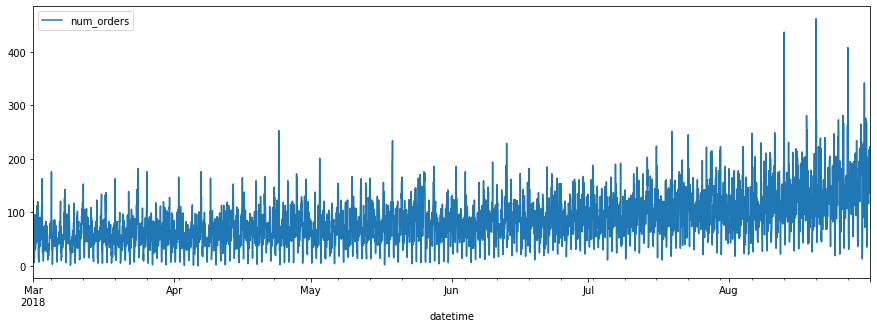

In [9]:
df.plot(figsize=(15,5));

#### Детальное изучение данных

Изучим данные за рандомную рабочую неделю марта, апреля и мая - эти месяцы идеально подходят для анализа как период до начала летних отпусков.

In [10]:
df_march_week = df['2018-03-12':'2018-03-18']
df_march_week['rolling_mean'] = df_march_week.rolling(6).mean()

df_april_week = df['2018-04-09':'2018-04-15']
df_april_week['rolling_mean'] = df_april_week.rolling(6).mean()

df_may_week = df['2018-05-14':'2018-05-20']
df_may_week['rolling_mean'] = df_may_week.rolling(6).mean()

Построим графики.

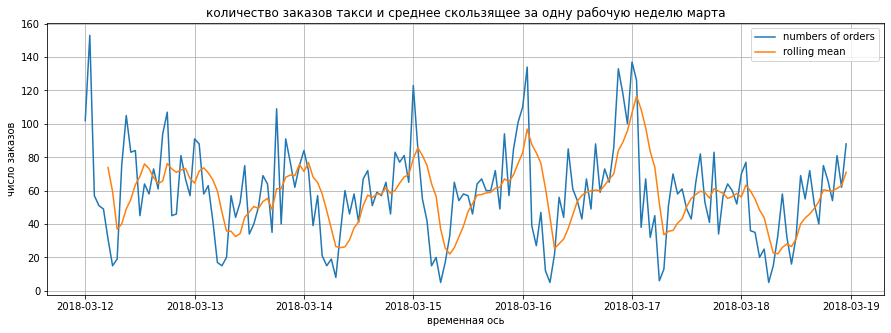

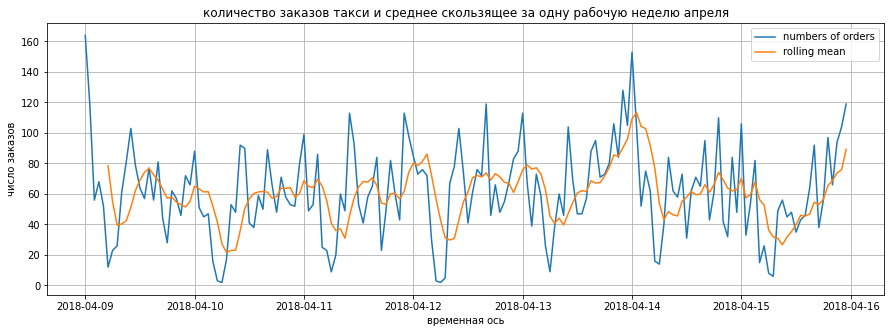

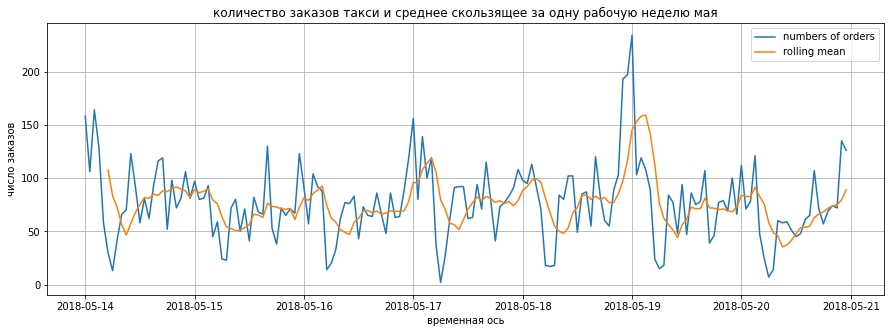

In [11]:
plt.figure(figsize=(15,5))

plt.title('количество заказов такси и среднее скользящее за одну рабочую неделю марта')

plt.plot(df_march_week);

plt.legend(['numbers of orders',
            'rolling mean'])

plt.ylabel('число заказов', fontsize=10)
plt.xlabel('временная ось', fontsize=10)

plt.grid()

plt.show()

plt.figure(figsize=(15,5))

plt.title('количество заказов такси и среднее скользящее за одну рабочую неделю апреля')

plt.plot(df_april_week);

plt.legend(['numbers of orders',
            'rolling mean'])

plt.ylabel('число заказов', fontsize=10)
plt.xlabel('временная ось', fontsize=10)

plt.grid()

plt.show()

plt.figure(figsize=(15,5))

plt.title('количество заказов такси и среднее скользящее за одну рабочую неделю мая')

plt.plot(df_may_week);

plt.legend(['numbers of orders',
            'rolling mean'])

plt.ylabel('число заказов', fontsize=10)
plt.xlabel('временная ось', fontsize=10)

plt.grid()

plt.show()

Саммари по всем графикам:
- четкой тенденции к увеличению или уменьшению заказов по ходу недели нет;
- наиболее загруженный период - ночь с пятницы на субботу;
- в среду и четверг такси вызывают чаще, чем в понедельник и вторник;
- после пятничного бума утром в субботу наблюдается падение количества заказов;
- в воскресенье к вечеру количество заказов растет.

### Декомпозиция временного ряда

#### Датафрейм полностью

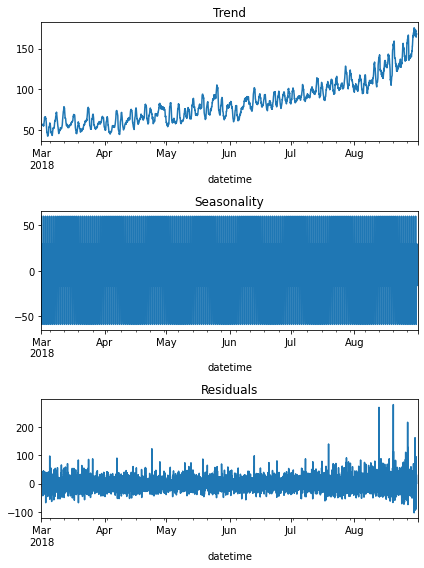

In [12]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

- Наблюдается общий тренд к увеличению заказов такси.
- График сезонности не дает какой-либо информации, т.к. для временного ряда такой длины (полгода) сезонность слишком узкое понятие. Если бы временной ряд был длиной в несколько лет, то на графике сезонности можно было бы отметить изменение количества заказов в зависимости от времени года/месяца.
- По графику остатка сделать какие-либо выводу не могу.

#### Одна неделя

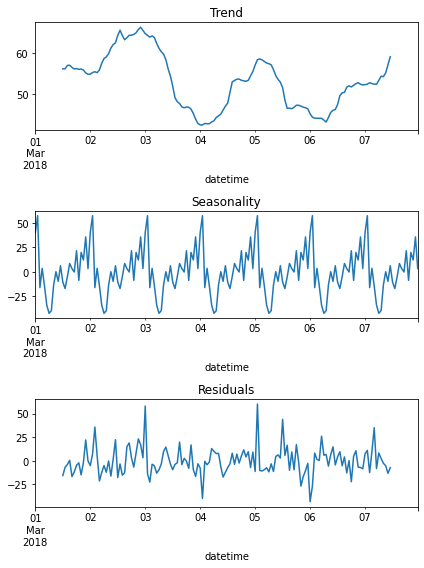

In [13]:
decomposed = seasonal_decompose(df['2018-03-01':'2018-03-07'])

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

- Общий тренд не просматривается.
- График сезонности показывает, что такси чаще заказывают в вечерне-ночное время, и почти совсем не вызывают в раннее утро. С началом рабочего дня наблюдается рост числа заказов, который спадает к обеду, а с его началом вновь проявляется.

#### Один месяц

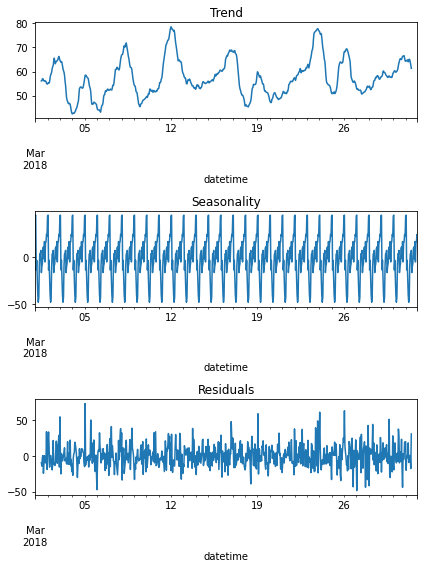

In [14]:
decomposed = seasonal_decompose(df['2018-03'])

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

- Общий тренд не просматривается.
- График сезонности также показывает зависимость числа заказов от времени суток.

## Подготовка данных к обучению

### Создание признаков для временного ряда

Напишем функцию, которая создаст признаки для временного ряда.

In [16]:
def feature_maker(df, window_size, num_lags):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['rolling_mean'] = df['num_orders'].rolling(window_size).mean()
    
    for lag in range(1, num_lags+1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)

In [17]:
window_size = 24
num_lags = 1

feature_maker(df,window_size,num_lags)

df = df[window_size:]

df

,num_orders,dayofweek,hour,rolling_mean,lag_1
datetime,,,,,
2018-03-02 00:00:00,90,4,0,55.416667,58.0
2018-03-02 01:00:00,120,4,1,56.875000,90.0
2018-03-02 02:00:00,75,4,2,57.041667,120.0
2018-03-02 03:00:00,64,4,3,56.958333,75.0
2018-03-02 04:00:00,20,4,4,56.000000,64.0
...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,167.541667,207.0
2018-08-31 20:00:00,154,4,20,168.041667,136.0
2018-08-31 21:00:00,159,4,21,166.416667,154.0


### Подготовка выборок

Разделим данные на обучающую и тестовую выборки, на фичи и таргет.

In [18]:
(
    X_train, X_test,
    y_train, y_test
) = train_test_split(
    df.drop('num_orders', axis=1),
    df['num_orders'],
    test_size=.1,
    random_state=12345,
    shuffle=False
)

## Машинное обучение

### LinearRegression

In [20]:
param_set = {}

tscv = TimeSeriesSplit(n_splits=3)

grid_lr = GridSearchCV(LinearRegression(), param_grid=param_set,
                       scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)

In [21]:
%%time

grid_lr.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 23.2 ms, sys: 669 µs, total: 23.8 ms
Wall time: 22.5 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LinearRegression(), n_jobs=-1, param_grid={},
             scoring='neg_root_mean_squared_error', verbose=1)

In [22]:
%%time

grid_lr.predict(X_train)

CPU times: user 473 µs, sys: 37.4 ms, total: 37.9 ms
Wall time: 8.37 ms


array([ 54.29110827,  69.23565826,  82.61336372, ..., 117.20084435,
       129.14085231, 122.60840886])

In [23]:
grid_lr.best_score_, grid_lr.best_params_

(-32.23723616263796, {})

### DecisionTreeRegressor

In [24]:
param_set = {
    'min_samples_split': [3, 5, 7]
}

grid_dtr = GridSearchCV(DecisionTreeRegressor(random_state=12345), param_grid=param_set, 
                       scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)

In [25]:
%%time

grid_dtr.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
CPU times: user 114 ms, sys: 3.58 ms, total: 118 ms
Wall time: 117 ms


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=DecisionTreeRegressor(random_state=12345), n_jobs=-1,
             param_grid={'min_samples_split': [3, 5, 7]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [26]:
%%time

grid_dtr.predict(X_train)

CPU times: user 4.47 ms, sys: 110 µs, total: 4.58 ms
Wall time: 3.48 ms


array([123.5       , 107.75      ,  53.5       , ..., 115.33333333,
        94.16666667, 159.5       ])

In [27]:
grid_dtr.best_score_, grid_dtr.best_params_

(-32.6687253391101, {'min_samples_split': 7})

### LGBMRegressor

In [28]:
param_set = {
    'num_leaves': [21],
    'learning_rate': [0.1],
    'max_depth': [7],
    'n_estimators': [100],
}

grid_lgbm = GridSearchCV(lgb.LGBMRegressor(random_state=12345), param_grid=param_set, 
                       scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)

In [29]:
%%time

grid_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 39.8 s, sys: 436 ms, total: 40.3 s
Wall time: 40.5 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [7],
                         'n_estimators': [100], 'num_leaves': [21]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [30]:
%%time

grid_lgbm.predict(X_train)

CPU times: user 13.3 ms, sys: 0 ns, total: 13.3 ms
Wall time: 8.33 ms


array([ 95.8780228 ,  72.83051998,  53.64852152, ..., 103.39186834,
       109.4581968 , 134.64221095])

In [31]:
grid_lgbm.best_score_, grid_lgbm.best_params_

(-25.792555924310374,
 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'num_leaves': 21})

### CatBoostRegressor

In [32]:
param_set = {
      'depth'         : [4,7],
      'learning_rate' : [0.02,0.04],
      'iterations'    : [5,10]
}

grid_catboost = GridSearchCV(CatBoostRegressor(random_state=12345), param_grid=param_set, 
                       scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)

In [33]:
%%time

grid_catboost.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
0:	learn: 29.0587321	total: 46.7ms	remaining: 187ms
1:	learn: 28.8279363	total: 47.1ms	remaining: 70.7ms
2:	learn: 28.5889027	total: 47.4ms	remaining: 31.6ms
3:	learn: 28.3793534	total: 47.7ms	remaining: 11.9ms
4:	learn: 28.1259755	total: 48.1ms	remaining: 0us
0:	learn: 31.7648161	total: 581us	remaining: 2.33ms
1:	learn: 31.5563250	total: 1.12ms	remaining: 1.69ms
2:	learn: 31.3375550	total: 1.57ms	remaining: 1.05ms
3:	learn: 31.1348671	total: 2.06ms	remaining: 515us
4:	learn: 30.8857716	total: 2.44ms	remaining: 0us
0:	learn: 33.6665309	total: 667us	remaining: 2.67ms
1:	learn: 33.4067655	total: 1.38ms	remaining: 2.07ms
2:	learn: 33.1557773	total: 2.11ms	remaining: 1.41ms
3:	learn: 32.9467130	total: 2.67ms	remaining: 668us
4:	learn: 32.6767994	total: 3.14ms	remaining: 0us
0:	learn: 28.8137738	total: 379us	remaining: 1.52ms
1:	learn: 28.3667953	total: 877us	remaining: 1.31ms
2:	learn: 27.9150993	total: 1.35ms	remaining: 902us
3:	

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f45645b8640>,
             n_jobs=-1,
             param_grid={'depth': [4, 7], 'iterations': [5, 10],
                         'learning_rate': [0.02, 0.04]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [34]:
%%time

grid_catboost.predict(X_train)

CPU times: user 2.98 ms, sys: 109 µs, total: 3.09 ms
Wall time: 1.83 ms


array([81.90124186, 79.19885207, 78.92266407, ..., 85.599544  ,
       86.28971044, 85.599544  ])

In [35]:
grid_catboost.best_score_, grid_catboost.best_params_

(-37.95590468692136, {'depth': 7, 'iterations': 10, 'learning_rate': 0.04})

### Метрики моделей

In [36]:
results = pd.DataFrame(
    np.array([grid_lr.best_score_,grid_dtr.best_score_,grid_lgbm.best_score_,grid_catboost.best_score_]) * -1,
    index=['LinearRegression','DecisionTree','LGBM','CatBoost'])

display(results)
print(f'Наименьшее значение метрики - {results[0].abs().min():.2f} \
- у {results[results[0].abs() == results[0].abs().min()].index}')

,0
LinearRegression,32.237236
DecisionTree,32.668725
LGBM,25.792556
CatBoost,37.955905


Наименьшее значение метрики - 25.79 - у Index(['LGBM'], dtype='object')


### Проверка лучшей модели

Проверим лучшую модель на тестовой выборке.

In [37]:
THRESHOLD_RMSE = 48

In [38]:
start = time.time()
grid_lgbm.best_estimator_.fit(X_train, y_train)
fit_time = time.time() - start
pred = grid_lgbm.best_estimator_.predict(X_test)
pred_time = time.time() - start
score = mean_squared_error(y_test, pred) ** .5
print(f'LGBMRegressor\nFit time: {fit_time}\nPredict time: {pred_time}\nScore: {score}')
print()

if score < THRESHOLD_RMSE:
    print(f'Значение метрики RMSE на тестовой выборке составило {score:.2f}, \
что оказалось меньше порогового значения {THRESHOLD_RMSE}.\nМы успешно справились с заданием.')
elif score >= THRESHOLD_RMSE:
    print(f'Значение метрики RMSE на тестовой выборке составило {score:.2f}, \
что оказалось больше порогового значения {THRESHOLD_RMSE}.\nЭто фиаско.')    

LGBMRegressor
Fit time: 0.2993464469909668
Predict time: 0.3934299945831299
Score: 41.052561589743675

Значение метрики RMSE на тестовой выборке составило 41.05, что оказалось меньше порогового значения 48.
Мы успешно справились с заданием.


#### Графики результатов модели

Построим графики с таргетом и предсказаниями модели, чтобы определить наиболее проблемные участки time series для модели.

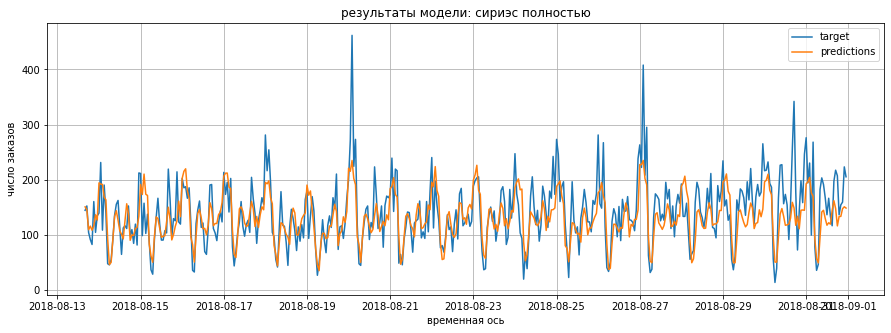

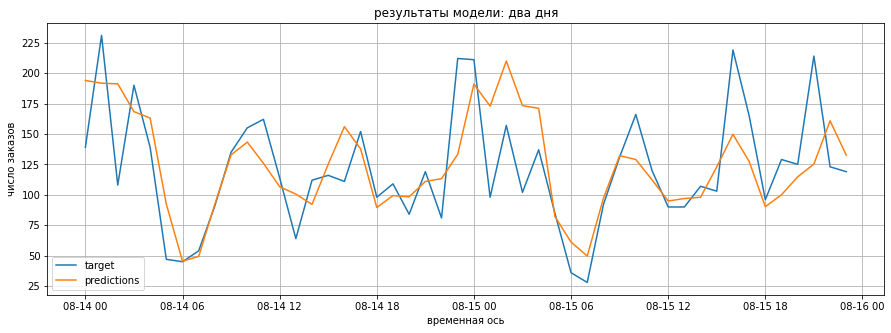

In [39]:
plt.figure(figsize=(15,5))

plt.title('результаты модели: сириэс полностью')

plt.plot(y_test);
plt.plot(pd.Series(pred, index=y_test.index));

plt.legend(['target',
            'predictions'])

plt.ylabel('число заказов', fontsize=10)
plt.xlabel('временная ось', fontsize=10)

plt.grid()

plt.show()



plt.figure(figsize=(15,5))

plt.title('результаты модели: два дня')

plt.plot(y_test['2018-08-14':'2018-08-15']);
plt.plot(pd.Series(pred, index=y_test.index)['2018-08-14':'2018-08-15']);

plt.legend(['target',
            'predictions'])

plt.ylabel('число заказов', fontsize=10)
plt.xlabel('временная ось', fontsize=10)

plt.grid()

plt.show()

## Общий вывод

На основе данных о заказах такси в аэропортах были проведены ряд исследований и машинное обучение. Цель: спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

Важное условие: значение метрики RMSE на тестовой выборке должно быть не больше 48.

В ходе работы был **открыт и изучен файл с данными**, был проведен **ресамплинг** данных по одному часу.

Далее были отдельно изучены данные за рандомную рабочую неделю марта, апреля и мая - эти месяцы идеально подходят для анализа как период до начала летних отпусков. Были сделаны следующие выводы:
- четкой тенденции к увеличению или уменьшению заказов по ходу недели нет;
- наиболее загруженный период - ночь с пятницы на субботу;
- в среду и четверг такси вызывают чаще, чем в понедельник и вторник;
- после пятничного бума утром в субботу наблюдается падение количества заказов;
- в воскресенье к вечеру количество заказов растет.

Затем, в ходе изучения данных, была произведена **декомпозиция временного ряда** на тренд и сезонность.

После этого **данные были подготовлены к обучению**. Созданы признаки для временного ряда - год, месяц, число, день недели, час вызова такси; **среднее скользящее с размером окна** 24; **сдвиг в количестве** 1. 

Далее было проведено **машинное обучение** четырех моделей: LinearRegression, DecisionTreeRegressor, LGBMRegressor, CatBoostRegressor.

По результатам проверки **наименьшее значение метрики RMSE - 25.79 - оказалось у модели LGBMRegressor**.

**На тестовой выборке данная модель также показала хороший результат: значение RMSE составляет 41.05**. Т.к. это меньше порогового значения 48, можно считать, что мы успешно справились с заданием.

**Итог**: рекомендую заказчику обратить внимание на модель LGBMRegressor, а также на создание следующих признаков - день недели, час вызова такси, среднее скользящее с размером окна 24 часа; сдвиг в количестве 1.